In [1]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas
import requests
import osgeo.osr
import tqdm
print(matplotlib.style.available)
matplotlib.style.use('bmh')
%matplotlib inline

['seaborn-dark', 'seaborn-white', 'fivethirtyeight', 'seaborn-darkgrid', 'seaborn-muted', 'seaborn-talk', 'seaborn-pastel', 'bmh', 'classic', 'seaborn-dark-palette', 'seaborn-poster', 'seaborn', 'seaborn-notebook', 'seaborn-bright', 'grayscale', 'seaborn-colorblind', 'seaborn-paper', 'ggplot', 'seaborn-whitegrid', 'dark_background', 'seaborn-ticks', 'seaborn-deep']


In [20]:
# alternative  (non-maintained? source https://data.overheid.nl/data/dataset/geotop)
url = 'http://dinodata.nl/opendap/GeoTOP/geotop.nc'

In [21]:
ds = netCDF4.Dataset(url)

In [73]:

x = ds.variables['x'][:]
y = ds.variables['y'][:]
z = ds.variables['z'][:]
z_0 = np.where(z == 0)[0]
z_min_10 = np.where(z == -10)[0]
litho = ds.variables['lithok'][::5, ::5, z_0]

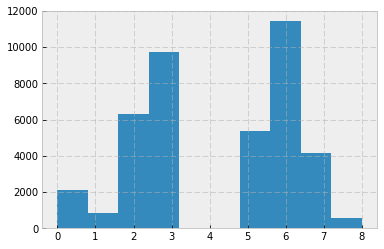

In [74]:
_ = plt.hist(litho[~litho.mask])

In [75]:
labels = {
    0: "mensen",
    1: "veen",
    2: "klei",
    3: "zandige klei",
    4: "lithoklasse 4",
    5: "fijn zand",
    6: "middelfijn zand",
    7: "grof zand",
    8: "grind",
    9: "schelpen"
}

In [76]:
import matplotlib.colors
import matplotlib.cm
colors = [
    '#3344ffff', # ophooglaag
    '#845F4Cff', # organisch
    '#734222ff', # klei
    '#B99F71ff', # zandige klei
    '#ff0000ff', # litho 4
    '#E7D1C1ff', # fijn 
    '#c2b280ff', # middelfijn
    '#969CAAff', # grof
    '#D0D6D6ff', # grind
    '#E5E5DBff'  # schelp
]
geotop_cmap = matplotlib.colors.ListedColormap(
    colors
)

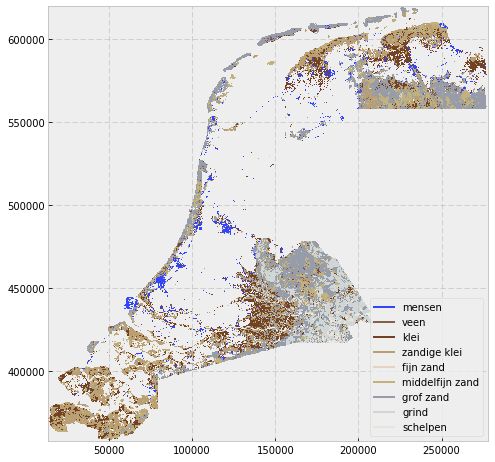

In [77]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(np.squeeze(litho.T), origin='top', extent=(x[0], x[-1], y[0], y[-1]), cmap=geotop_cmap)
for label in labels:
    if label == 4:
        continue
    ax.plot(x[0], y[0], color=colors[label], label=labels[label])
ax.legend(loc='lower right')

    

In [9]:
#
url = "https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus/"
params = {
    "CatalogusFilter": 
    {
        "Eenheden": True,
        "Grootheden":True,
        "Hoedanigheden":True
    }
}   
resp = requests.post(url, json=params)
result = resp.json()


In [10]:
locaties = pandas.DataFrame.from_dict(result['LocatieLijst'])
locaties.head()

,Code,Coordinatenstelsel,Locatie_MessageID,Naam,X,Y
0,PUTTHK,25831,71501,Puttershoek,607953.756126,5.741249e+06
1,PAMPOT,25831,71567,Pampus oost,642137.610530,5.803852e+06
2,DORDDWTILT,25831,71673,Dordrecht drinkwaterinlaat,618550.924833,5.741146e+06
3,VOLKRK02,25831,72041,"Volkerak, meetplaats 02",593887.320784,5.724213e+06
4,TERNZLTG,25831,72841,Terneuzen landtong,557480.132067,5.685960e+06


In [11]:
aquo = pandas.DataFrame.from_dict(result['AquoMetadataLijst']).set_index('AquoMetadata_MessageID')
aquo.ix[60]

Eenheid                            {'Omschrijving': 'centimeter', 'Code': 'cm'}
Grootheid                     {'Omschrijving': 'Waterhoogte', 'Code': 'WATHTE'}
Hoedanigheid                  {'Omschrijving': 't.o.v. Normaal Amsterdams Pe...
Parameter_Wat_Omschrijving    Waterhoogte Oppervlaktewater t.o.v. Normaal Am...
Name: 60, dtype: object

In [12]:
aquolocaties = pandas.DataFrame.from_dict(result['AquoMetadataLocatieLijst'])

In [13]:
# only locations with waterlevel measurements relative to NAP 
selected_locaties = aquolocaties[aquolocaties.AquoMetaData_MessageID == 60]
# get location information
selected_locaties = pandas.merge(locaties, selected_locaties)
# selected_locaties.X /= 10.0
# selected_locaties.Y /= 10.0

In [14]:
in_bbox = np.logical_and.reduce([
    selected_locaties.X >= x[0],
    selected_locaties.X < x[-1]
#     selected_locaties.Y >= y[0],
#     selected_locaties.Y < y[1],       
    ])
selected_locaties.ix[in_bbox]

,Code,Coordinatenstelsel,Locatie_MessageID,Naam,X,Y,AquoMetaData_MessageID
42,NORTHSS,25831,84652,North Shields,216034.606007,6.104555e+06,60
169,ABDN,25831,84867,Aberdeen,193050.063557,6.344694e+06,60
356,WICK,25831,85286,Wick,144966.540097,6.492968e+06,60
662,LERWK,25831,85080,Lerwick,270493.564566,6.675239e+06,60
736,LEITH,25831,85083,Leith,115401.645430,6.221326e+06,60


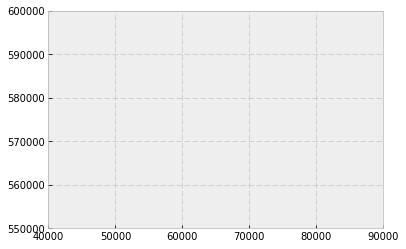

In [15]:
plt.plot(selected_locaties.X, selected_locaties.Y, 'k.')
# plt.xlim(0.4e6, 0.9e6)
# plt.ylim(0.55e7, 0.60e7)
plt.xlim(0.4e5, 0.9e5)
plt.ylim(0.55e6, 0.60e6)
plt.plot(155000.0, 463000.0, 'rx')

In [16]:
utm = osgeo.osr.SpatialReference()
rd = osgeo.osr.SpatialReference()
utm.ImportFromEPSG(25831)
# utm.ImportFromEPSG(32631)
rd.ImportFromEPSG(28992)
utm2rd = osgeo.osr.CoordinateTransformation(utm, rd)
pts = np.array(selected_locaties[['X', 'Y']])
pts_rd = np.array(utm2rd.TransformPoints(pts))
selected_locaties['X_rd'] = pts_rd[:, 0]
selected_locaties['Y_rd'] = pts_rd[:, 1]

(358000, 619500)

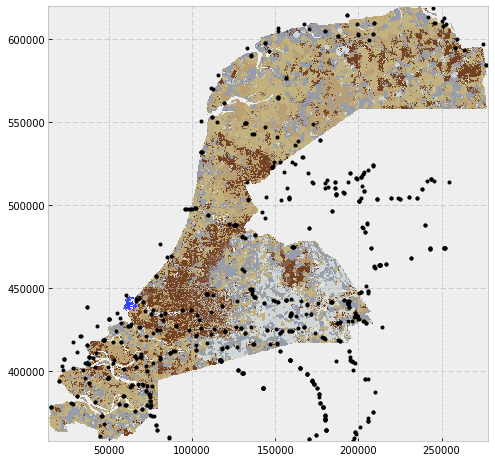

In [17]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(np.squeeze(litho.T), origin='top', extent=(x[0], x[-1], y[0], y[-1]), cmap=geotop_cmap)
ax.plot(selected_locaties.X_rd, selected_locaties.Y_rd, 'k.')
ax.set_xlim(x[0], x[-1])
ax.set_ylim(y[0], y[-1])


In [18]:
selected_locaties[selected_locaties.Naam.apply(lambda x:'arl' in x)]

,Code,Coordinatenstelsel,Locatie_MessageID,Naam,X,Y,AquoMetaData_MessageID,X_rd,Y_rd
289,HARL,25831,83458,Harlingen,661156.301158,5.894528e+06,60,156614.935006,576554.039619
412,HARLGN,25831,84096,Harlingen,661021.585505,5.894519e+06,60,156480.000013,576550.000688


In [19]:
stations = ['DENHDR', 'IJMH', 'HOEKVHLD', 'VLIS', 'VLISSGN', 'DELFZL', 'DLFZ', 'HARLGN', 'HARL']

In [20]:
main_stations = selected_locaties.ix[selected_locaties.Code.apply(lambda x: x in stations)].copy()


In [21]:
in_model = np.logical_and.reduce([
    main_stations.X_rd >= x[0],
    main_stations.X_rd < x[-1],
    main_stations.Y_rd >= y[0],
    main_stations.Y_rd < y[-1]
])
main_stations['in_model'] = in_model
main_stations['in_model'].all()


True

In [22]:
main_stations['X_idx'] = np.searchsorted(x, main_stations.X_rd)
main_stations['Y_idx'] = np.searchsorted(y, main_stations.Y_rd)

In [23]:
lithos = {}
for i, station in main_stations.iterrows():
    litho = ds.variables['lithok'][station.X_idx, station.Y_idx, :]
    lithos[station.Code] = litho

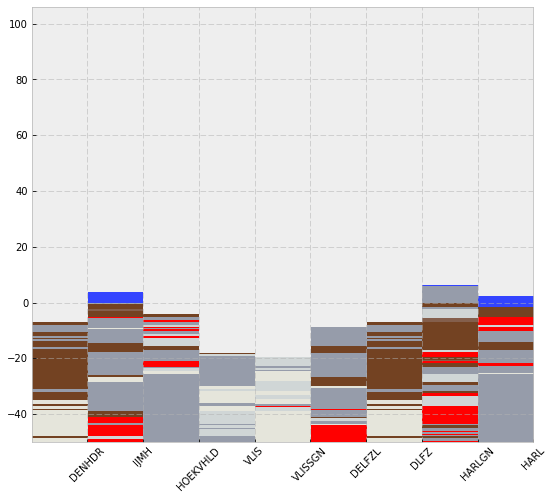

In [24]:
litho_img = np.ma.masked_equal(list(lithos.values()), -127).T
fig, ax = plt.subplots(figsize=(13, 8))
ax.imshow(litho_img, origin='top', extent=(0, 9, z[0], z[-1]), cmap=geotop_cmap)
ax.set_aspect(0.05)
_ = ax.xaxis.set_ticks(list(range(1, len(stations) + 1)))
_ = ax.xaxis.set_ticklabels(stations, rotation=45)






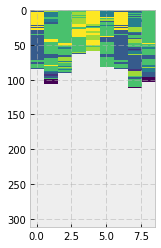

In [25]:
fig, ax = plt.subplots()
ax.imshow(litho_img.copy())
ax.set_aspect(0.05)

In [26]:
litho_img.max()

7